In [1]:
import cvxpy as cp
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from cvx.covariance.ewma import iterated_ewma, _ewma_mean
from cvx.covariance.combination import from_sigmas
from cvx.covariance.regularization import regularize_covariance
from experiments.utils.experiment_utils import add_to_diagonal, log_likelihood, ecdf, log_likelihood_sequential, log_likelihood_regularized

sns.set()
sns.set(font_scale=1.5)

%load_ext autoreload
%autoreload 2

# Data

In [2]:
# data = pd.read_csv("/Users/kasper/Documents/Stanford/Research/Data/SP500/asset_data_2000_to_2023.csv", index_col=0, parse_dates=True)

# data = data.drop(["TICKER", "PERMCO"], axis=1)
# prices = pd.pivot_table(data, values='PRC', index='date', columns='PERMNO', fill_value=None)
# prices.index = pd.to_datetime(prices.index, format="%Y-%m-%d")
# returns = prices.pct_change().dropna(axis=0, how="all")
returns = 100*pd.read_csv("../data/returns_large_universe.csv", index_col=0, parse_dates=True)

In [91]:
returns.shape

(5787, 238)

In [3]:
### No mean adjustment
cm_iewma_pairs = [(63, 125), (125, 250), (250, 500), (500, 1000)]

# CM-IEWMA
print("Computing IEWMAs")
iewmas = {f"{pair[0]}-{pair[1]}": list(iterated_ewma(returns, vola_halflife=pair[0], cov_halflife=pair[1], min_periods_vola=63, min_periods_cov=250)) for pair in cm_iewma_pairs}
Sigmas = {key: {item.time: item.covariance for item in iewma} for key, iewma in iewmas.items()}
print("Done computing IEWMAs")

results = list(from_sigmas(Sigmas, returns, means=None).solve(window=10))

Computing IEWMAs
Done computing IEWMAs


100%|██████████| 5466/5466 [11:18<00:00,  8.06it/s]  


In [4]:
covariance_no_reg = {result.time: result.covariance for result in results}

In [26]:
ll_r5 = log_likelihood_regularized(returns, covariance_no_reg, r=5)


In [5]:
print(0)
ll_r1 = log_likelihood_regularized(returns, covariance_no_reg, r=1)

print(1)
ll_r5 = log_likelihood_regularized(returns, covariance_no_reg, r=5)

print(2)
ll_r10 = log_likelihood_regularized(returns, covariance_no_reg, r=10)

print(3)
ll_r20 = log_likelihood_regularized(returns, covariance_no_reg, r=20)

print(4)
ll_r50 = log_likelihood_regularized(returns, covariance_no_reg, r=50)

print(5)
ll_r75 = log_likelihood_regularized(returns, covariance_no_reg, r=75)

print(6)
ll_r100 = log_likelihood_regularized(returns, covariance_no_reg, r=100)

print(7)
ll_r150 = log_likelihood_regularized(returns, covariance_no_reg, r=150)

print(8)
ll_r238 = log_likelihood_regularized(returns, covariance_no_reg, r=238)

print(9)
ll_no_reg = log_likelihood_regularized(returns, covariance_no_reg, r=None)

0
1
2
3
4
5
6
7


In [57]:
ll_r238 = log_likelihood_regularized(returns, covariance_no_reg, r=238)

In [60]:
all_lls = [ll_r1, ll_r5, ll_r10, ll_r20, ll_r50, ll_r75, ll_r100, ll_r150,
ll_r237, ll_r238, ll_no_reg]

names = ['r=1', 'r=5', 'r=10', 'r=20', 'r=50', 'r=75', 'r=100', 'r=150',
'r=237', 'r=238', 'r=None']

log_likelihoods = {}

for i in range(len(all_lls)):
    log_likelihoods[names[i]] = all_lls[i]

In [83]:
# Save to csv

for i, ll in enumerate(all_lls):
    ll.to_csv(f"results/after_comb_ll_{names[i]}.csv")

In [77]:
start_date = [*covariance_no_reg.keys()][250]
end_date = [*covariance_no_reg.keys()][-1]

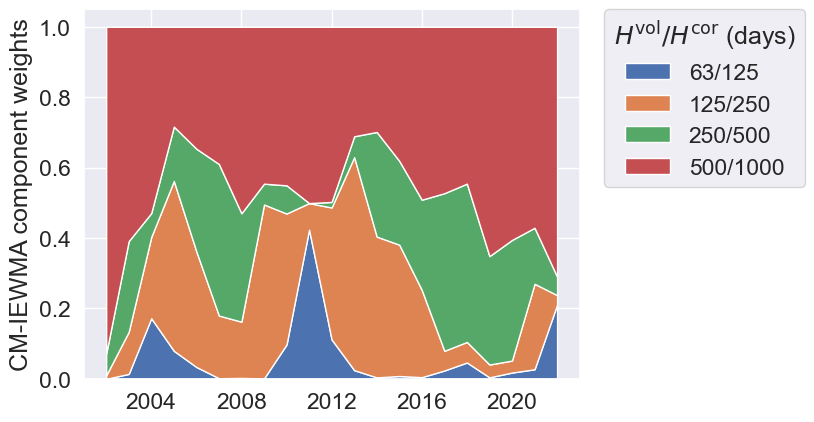

In [14]:
yearly_weights  = pd.DataFrame(weights).T.resample("Y").mean().loc[start_date:end_date]

plt.stackplot(yearly_weights.index, yearly_weights.values.T, labels=[f"{pair[0]}/{pair[1]}" for pair in cm_iewma_pairs])
plt.ylabel("CM-IEWMA component weights")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0., title=r"$H^{\mathrm{vol}}/H^{\mathrm{cor}}$ (days)");

# Log-likelihood

In [68]:
log_likelihoods['r=238'].mean()

-423.55163425312736

In [79]:
log_likelihoods['r=237'].loc[start_date:end_date].mean()

-413.50975222412444

<Axes: >

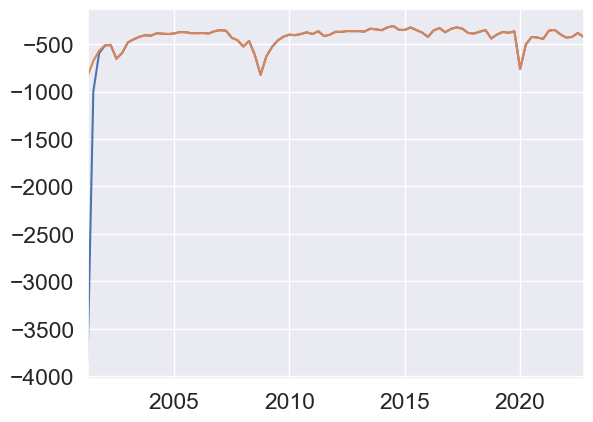

In [75]:
log_likelihoods['r=237'].resample("Q").mean().plot()
log_likelihoods['r=238'].resample("Q").mean().plot()
# plt.ylim(-800,-300);

Text(0, 0.5, 'Average quarterly log-likelihood')

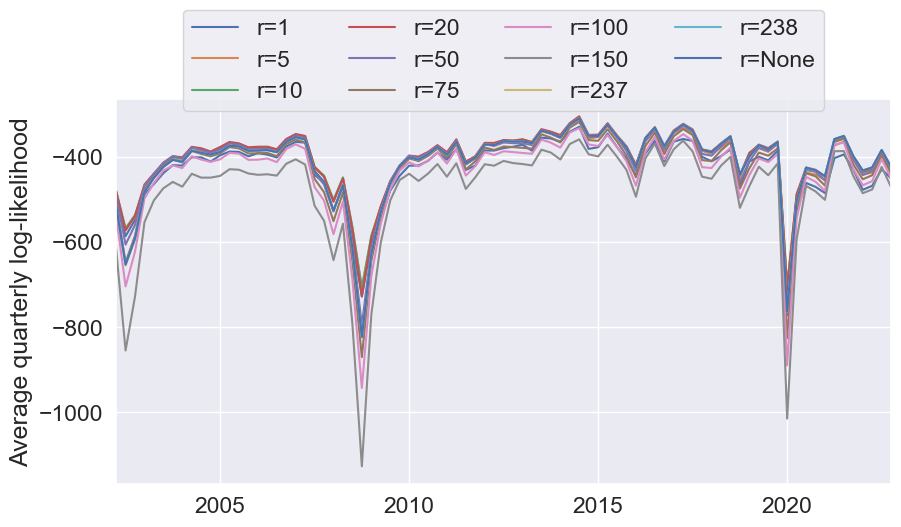

In [81]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
for name in names[:]:
    log_likelihoods[name].loc[start_date:end_date].resample("Q").mean().plot(label=name)
plt.legend(bbox_to_anchor=(0.5, 1.1), loc='center', ncols=4, labels=names, scatterpoints=1, markerscale=5);
plt.ylabel("Average quarterly log-likelihood")
# plt.ylim(-500,-300);

2001-04-11   -536.549302
2001-04-12   -526.330074
2001-04-16   -579.948334
2001-04-17   -633.832988
2001-04-18   -628.894689
                 ...    
2022-12-22   -359.949425
2022-12-23   -363.658877
2022-12-27   -355.927857
2022-12-28   -368.066196
2022-12-29   -342.137299
Length: 5465, dtype: float64

In [20]:
avg_log_likelihoods

[-432.1315474479847,
 -432.1315474479847,
 -409.1234105068322,
 -408.00171403742866,
 -416.50644936647126,
 -429.530873889966,
 -446.80861226961935,
 nan]

In [45]:
ll_no_reg

2001-04-11   -1114.188924
2001-04-12    -976.986255
2001-04-16   -1308.334875
2001-04-17   -3096.839944
2001-04-18   -1760.291572
                 ...     
2022-12-22    -306.165482
2022-12-23    -307.234550
2022-12-27    -297.767933
2022-12-28    -301.902283
2022-12-29    -279.913368
Length: 5465, dtype: float64

In [43]:
ll_r238

2001-04-11   -1114.188924
2001-04-12    -976.986255
2001-04-16   -1308.334875
2001-04-17   -3096.839944
2001-04-18   -1760.291572
                 ...     
2022-12-22    -306.165482
2022-12-23    -307.234550
2022-12-27    -297.767933
2022-12-28    -301.902283
2022-12-29    -279.913368
Length: 5465, dtype: float64

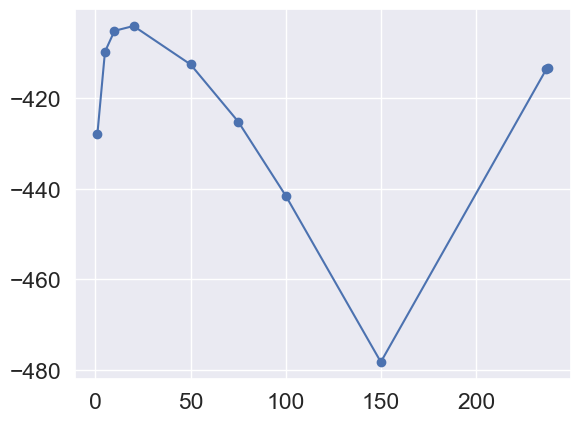

In [82]:
# Plot average log-likelihood vs r
rs = [1, 5, 10, 20, 50, 75, 100, 150, 237, 238]

avg_log_likelihoods = []
for name in names[:-1]:
    avg_log_likelihoods.append(log_likelihoods[name].loc[start_date:end_date].mean())

plt.plot(rs, avg_log_likelihoods, marker="o");

Text(0, 0.5, 'Average quarterly log-likelihood')

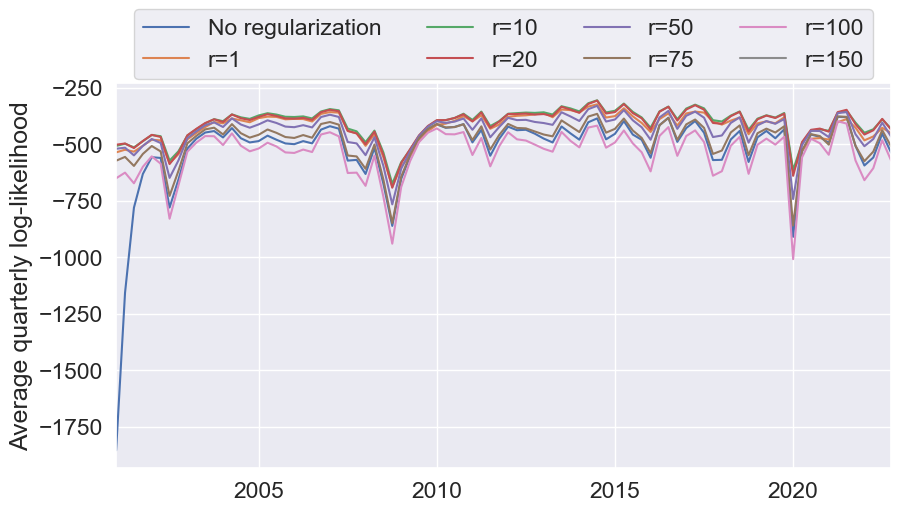

In [34]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
for name in names[:]:
    if name == 'PRESCIENT':
        log_likelihoods[name].resample("Q").mean().plot(label=name, c="k")
    else:
        log_likelihoods[name].resample("Q").mean().plot(label=name)
plt.legend(bbox_to_anchor=(0.5, 1.1), loc='center', ncols=4, labels=names, scatterpoints=1, markerscale=5);
plt.ylabel("Average quarterly log-likelihood")
# plt.ylim(-700,-200);

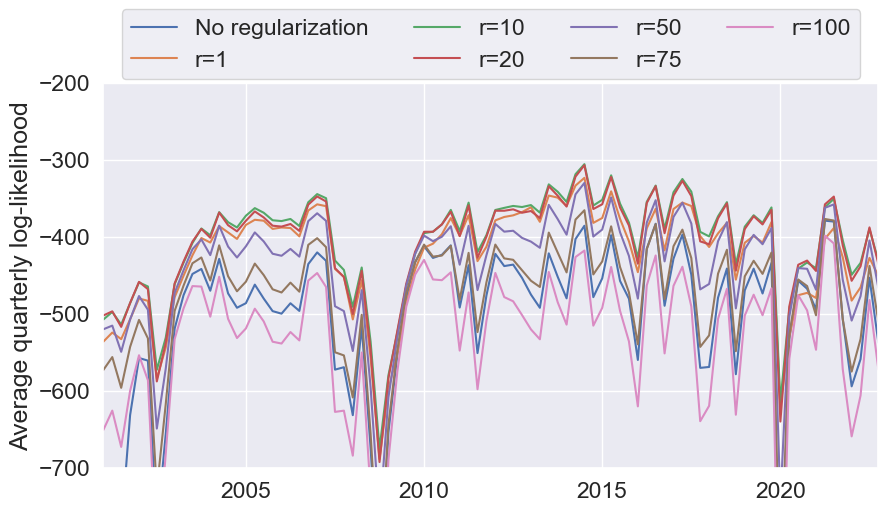

In [18]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
for name in names[:-1]:
    if name == 'PRESCIENT':
        log_likelihoods[name].resample("Q").mean().plot(label=name, c="k")
    else:
        log_likelihoods[name].resample("Q").mean().plot(label=name)
plt.legend(bbox_to_anchor=(0.5, 1.1), loc='center', ncols=4, labels=names, scatterpoints=1, markerscale=5);
plt.ylabel("Average quarterly log-likelihood")
plt.ylim(-700,-200);

In [22]:
# Plot average log-likelihood vs r
rs = [1, 10, 20, 50, 75, 100, 250]

avg_log_likelihoods = []
for name in names[1:-1]:
    avg_log_likelihoods.append(log_likelihoods[name].mean())

-423.5516342531238

In [85]:
ll_r1.mean()

-432.1315474479847

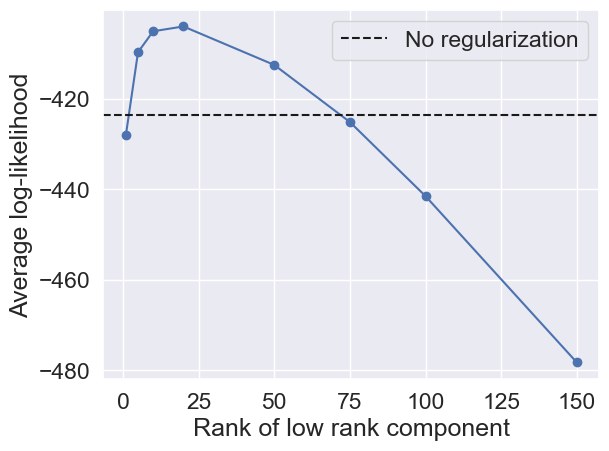

In [95]:
plt.plot(rs[:-2], avg_log_likelihoods[:-2], marker="o");
plt.xlabel("Rank of low rank component")
plt.ylabel("Average log-likelihood");
# Plot horizontal line for no regularization ll_no_reg.mean()
plt.axhline(ll_no_reg.mean(), c="k", ls="--", label="No regularization")
plt.legend();

# Old stuff

In [16]:
iewma = list(iterated_ewma(returns.loc['2010-01-01':], vola_halflife=63, cov_halflife=125, min_periods_vola=21, min_periods_cov=250))
iewma = {iterate.time: iterate.covariance for iterate in iewma}

iewma_clip = list(iterated_ewma(returns.loc['2010-01-01':], vola_halflife=63, cov_halflife=125, min_periods_vola=21, min_periods_cov=250, clip_at=4.2))
iewma_clip = {iterate.time: iterate.covariance for iterate in iewma_clip}

iewma_reg = list(iterated_ewma(returns.loc['2010-01-01':], vola_halflife=63, cov_halflife=125, min_periods_vola=21, min_periods_cov=250))
iewma_reg = {iterate.time: iterate.covariance for iterate in iewma_reg}
iewma_reg = dict(regularize_covariance(iewma_reg, r=50))

iewma_clip_reg = list(iterated_ewma(returns.loc['2010-01-01':], vola_halflife=63, cov_halflife=125, min_periods_vola=21, min_periods_cov=250, clip_at=4.2))
iewma_clip_reg = {iterate.time: iterate.covariance for iterate in iewma_clip_reg}
iewma_clip_reg = dict(regularize_covariance(iewma_clip_reg, r=50))

In [12]:
# Prescient predictor
prescient = {}
for t in returns.index:
    # get sample covariance matrix for corresponding year
    year = t.year
    cov = np.cov(returns.loc[returns.index.year == year].values, rowvar=False)
    mean = np.mean(returns.loc[returns.index.year == year].values, axis=0)
    prescient[t] = pd.DataFrame(cov+np.outer(mean,mean), index=returns.columns, columns=returns.columns)

# Log-likelihoods

In [15]:
iewma_reg

<generator object regularize_covariance at 0x7fa91b347270>

In [17]:
predictors = [iewma, iewma_clip, iewma_reg, iewma_clip_reg, prescient]

ll = {}

names = ["No clipping or regularization", "Clip at 4.2 sigma", "Low rank 50", "Clip at 4.2 sigma, low rank 50", "Prescient"]

for i, predictor in enumerate(predictors):
    print("Computing " + names[i] + " log-likelihood...")
    returns_temp = returns.loc[pd.Series(predictor).index].values[1:]
    times = pd.Series(predictor).index[1:]
    Sigmas_temp = np.stack([predictor[t].values for t in predictor.keys()])[:-1]

    # compute log-likelihood for 100*r since otherwise det(Sigma) is numerically zero
    ll[names[i]] = pd.Series(log_likelihood(returns_temp*100, Sigmas_temp*10000), index=times) 

Computing No clipping or regularization log-likelihood...
Computing Clip at 4.2 sigma log-likelihood...
Computing Low rank 50 log-likelihood...
Computing Clip at 4.2 sigma, low rank 50 log-likelihood...
Computing Prescient log-likelihood...


Mean Std Max

No clipping or regularization
592.534 2002.6 13633.03

Clip at 4.2 sigma
609.448 2016.349 13732.104

Low rank 50
403.692 1145.822 7522.574

Clip at 4.2 sigma, low rank 50
420.362 1164.703 7655.121

Prescient
0.0 0.0 0.0


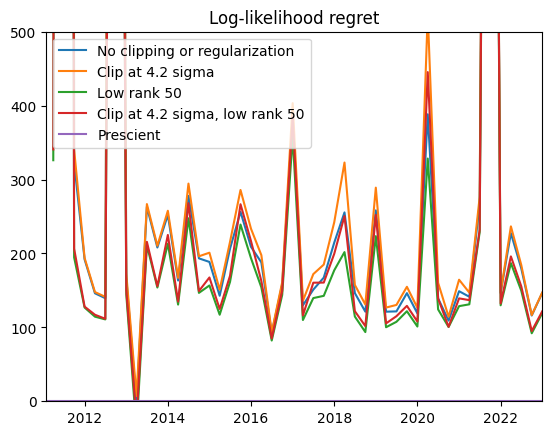

In [18]:
print("Mean", "Std", "Max")
for i, name in enumerate(ll):
    regret = (ll["Prescient"] - ll[name]).resample("Q").mean()
    plt.plot(regret, label=name)

    print("\n" + name)
    print(np.round(regret.mean(),3), np.round(regret.std(),3), np.round(regret.max(),3))
plt.legend()
plt.title("Log-likelihood regret")
plt.ylim(0,500)
plt.xlim([*predictors[0].keys()][0], returns.index[-1]);